# Spike Sorting Pipeline

This notebook walks through the steps to perform spikesorting on NWB data from the auditory experiments. 

In [1]:
#imports
import spikeinterface
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw 

#other imports
import matplotlib.pylab as plt
import numpy as np
import pynwb as py
import pandas as pd
import warnings

%matplotlib inline
warnings.simplefilter('ignore')

In [7]:
#REPLACE this with your file path to the nwb file in question
file_path = '/Users/macproizzy/Desktop/RVG16/RVG16_B06.nwb'
probe_file = '/Users/macproizzy/Desktop/electrodes_infoRVG163.csv'


If you want to look at the NWB data to make sure it is what you expect, you can use the cells below to do so. Otherwise, skip these cells. 

In [8]:
from pynwb import NWBFile, NWBHDF5IO, TimeSeries
import datetime

In [9]:
#check the NWB, this is a tone stimulus experiment 
io = NWBHDF5IO(file_path, 'r')
nwbfile_in = io.read()
nwbfile_in

root pynwb.file.NWBFile at 0x140643551517760
Fields:
  acquisition: {
    ECoG <class 'pynwb.ecephys.ElectricalSeries'>,
    Poly <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    ECoG <class 'pynwb.device.Device'>,
    Poly <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ECoG <class 'pynwb.ecephys.ElectrodeGroup'>,
    Poly <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: This is an acute rat experiment. Auditory stimuli are played to an anesthsized rat and electrophysiological measurements are made auditory cortex
  experimenter: ['Vanessa Gutierrez']
  file_create_date: [datetime.datetime(2021, 7, 30, 23, 8, 5, 82293, tzinfo=tzoffset(None, -25200))]
  identifier: ab66bd86-f1c5-11eb-bff2-ac1f6b76b038
  institution: Lawrence Berkeley National Lab
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: Bouchard Lab
  notes: All channels responded except obvious

In [10]:
io.close()

## Creating the Recording Extractor 

The following cells create the recording extractor, load the electrode geometry, and bandpass filter the data between 300 and 6000 Hz. There are a couple visualization cells as well for you to look at the data to make sure nothing weird is going on so far. 

After you are satisfied with the electrode geometry and an initial view of the data, the recording is cached for future use. 

In [11]:
#making recording extractor object, filtering
recording = se.NwbRecordingExtractor(file_path, "Poly")

In [25]:
#loading probe info 
recording_complete = recording.load_probe_file(probe_file = probe_file)

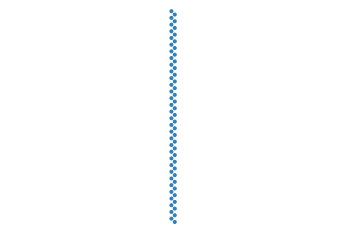

In [26]:
#make sure the geometry is what you expect
sw.plot_electrode_geometry(recording_complete)

In [27]:
# bandpass filter the recording
recording_flt = st.preprocessing.bandpass_filter(recording_complete, freq_min=300, freq_max=6000)

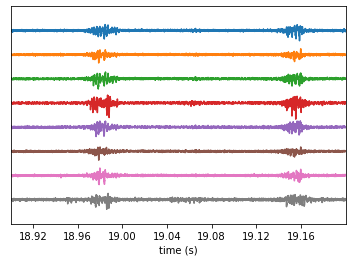

In [29]:
# look at a couple visualizations to make sure nothing weird is happening so far
# change the channel ids/trange if the ones filled in are not what you are looking for 
sw.plot_timeseries(recording_flt, channel_ids = [128, 129, 130, 131, 132, 133, 140, 141], trange = [18.9, 19.2])

In [ ]:
# fill in the path to save your recording 
save_path = '/Users/macproizzy/Desktop/ssRVG16/RVG16_B06.dat'
pickle_file = '/Users/macproizzy/Desktop/ssRVG16/RVG16_B06.pkl'

In [31]:
# cache recording
recording_cache = se.CacheRecordingExtractor(recording_flt, save_path = save_path)
recording_cache.dump_to_pickle(pickle_file)
# use recording_loaded_B10= se.load_extractor_from_pickle('R94_B10.pkl') in next session

*Note that in the next session/in a different notebook, you will be able to use se.load_extractor_from_pickle(pickle_file) to access the recording extractor as it is now*

## Sorting and Storing Results

The following cells check which sorters are installed, run the spike sorter, and cache the results. 

In [4]:
# check which sorters you have installed, more often than not I use mountainsort4
ss.installed_sorters()

['mountainsort4', 'spykingcircus']

In [32]:
# run the sorter
# NOTE: some of the kwargs may be different for some
sorting = ss.run_mountainsort4(recording_flt, filter = False, verbose = True, 
                                  num_workers = 8, grouping_property = 'group',
                                  output_folder= '/Users/macproizzy/Desktop/ssRVG16/mountainsort_Sept2')

Using 8 workers.
Using tmpdir: /tmp/tmpsjrowh18
Num. workers = 8
Preparing /tmp/tmpsjrowh18/timeseries.hdf5...
'end_frame' set to 35729408
Preparing neighborhood sorters (M=64, N=35729408)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmpsjrowh18
mountainsort4 run time 2748.45s


In [33]:
# Just to get a sense of how many units were found
print('The sorter found', len(sorting.get_unit_ids()), 'units')

The sorter found 140 units


In [ ]:
# Define your file paths
sorting_save_path = '/Users/macproizzy/Desktop/ssRVG16/sorting_B06.dat'
sorting_pickle = '/Users/macproizzy/Desktop/ssRVG16/sorting_B06.pkl'

In [34]:
# cache sorting 
sorting_cache = se.CacheSortingExtractor(sorting, save_path= sorting_save_path)
sorting_cache.dump_to_pickle(sorting_pickle)

# use sorting_loaded_B5= se.load_extractor_from_pickle('sorting_B510.pkl') in the next session or in a 
# different notebook

In [8]:
# export to phy for visualization 
st.postprocessing.export_to_phy(recording_loaded, 
                                sorting_spykingcircus, output_folder='phy_Sept8', verbose=True)

Converting to Phy format
Number of chunks: 19 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 19/19 [16:22<00:00, 51.70s/it]


Fitting PCA of 3 dimensions on 503576 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  /Users/macproizzy/Desktop/ssRVG16/phy_Sept8
Run:

phy template-gui  /Users/macproizzy/Desktop/ssRVG16/phy_Sept8/params.py
